In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.covariance import MinCovDet
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, f, chi2
import matplotlib

$\textbf{Empirical Exercise-Week 7}$  Page 474, Problem 9.33
Exchange Rates

In [34]:
Tab1 = pd.read_csv('xrate.csv')

In [35]:
Tab1.head(1)

,dateid01,di6_aus,di6_us,inf_aus,inf_us,ner
0,1/1/1986,NaN,NaN,NaN,NaN,71.6


In [5]:
di6_aus = np.array(Tab1.iloc[:,1]); di6_us = np.array(Tab1.iloc[:,2]);
inf_aus = np.array(Tab1.iloc[:,3]);  inf_us = np.array(Tab1.iloc[:,4]);
ner = np.array(Tab1.iloc[:,5]);
date1 = np.array(Tab1.iloc[:,0]);
date2 = np.array(Tab1.iloc[1:,0]);

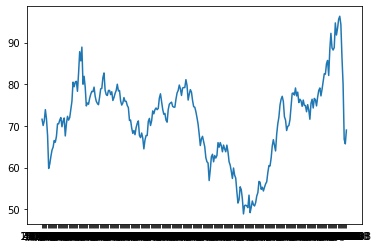

In [6]:
plt.plot(date1, ner)   # Plot of nominal exchange rate between US and Australia: US cents 
# cost of one AUS dollar; cheaper AUS dollar means appreciation of US dollar

C:\Users\mcnelis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


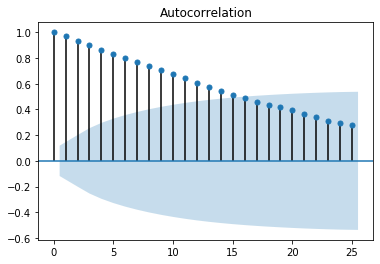

In [36]:
plot_acf(ner).show()  # autocorrelation function;  high degree of persistence

C:\Users\mcnelis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


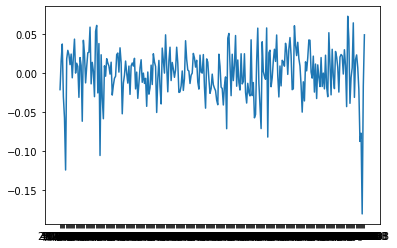

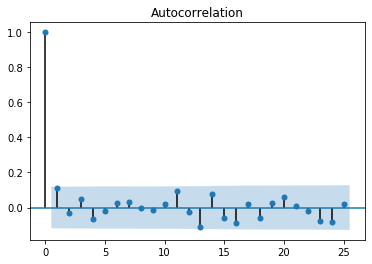

In [38]:
Dner = np.diff(np.log(ner))  # log first differenced exchange rate;
plt.plot(date2,Dner)
plot_acf(Dner).show()
# Dramatic difference in autocorrelation function

In [39]:
Dinf = inf_aus - inf_us;  Di6 = di6_aus - di6_us
y = Dner[1:]
x = np.vstack([np.ones(len(y)), Dinf[1:275], Dinf[0:274], Di6[1:275], Di6[0:274]]).T
y = y[1:]; x = x[1:, :]
print(y.shape, x.shape)

(273,) (273, 5)


In [40]:
results1 = sm.OLS(y,x).fit()
np.array([results1.params, results1.tvalues]).T

array([[-0.0005, -0.2482],
       [ 0.0022,  0.7079],
       [-0.0006, -0.1974],
       [ 0.0005,  2.1042],
       [ 0.0002,  0.7663]])

We see that the current interest different is the only significant regressor. Current inflation has the wrong sign, for sure.  But it is insignificant.
We drop regressors with the wrong sign.


In [41]:
xx = x[:,[0, 2, 3, 4]]
results2 = sm.OLS(y,xx).fit()
np.set_printoptions(precision =4,suppress=True)
np.array([results2.params, results2.tvalues]).T

array([[-0.0004, -0.1875],
       [-0.0011, -0.3594],
       [ 0.0005,  2.2716],
       [ 0.0002,  0.7954]])

C:\Users\mcnelis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


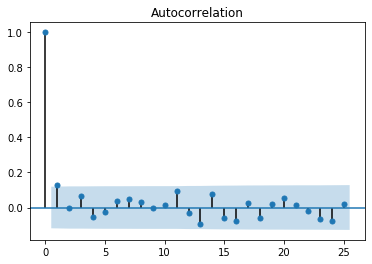

In [42]:
ehat = results2.resid   # Examine residuals
plot_acf(ehat).show()

Residuals look good by the autocorrelogram.

Breusch–Godfrey serial correlation LM

In [43]:
yyy = ehat[1:];  xxx= np.vstack([np.ones(len(yyy)), ehat[0:len(ehat)-1]]).T

In [44]:
results4 = sm.OLS(yyy,xxx).fit()
[results4.params, results4.tvalues, results4.rsquared]

[array([-0.0001,  0.1272]), array([-0.0705,  2.1117]), 0.01624762664399315]

In [45]:
nn = ((len(yyy))-2)
LMstat = nn * results4.rsquared;
LMstat

4.386859193878151

In [46]:
LMcdf = chi2.cdf(LMstat,2);
(1 - LMcdf)

0.11153357671700448

Close call on the LM test.

In [49]:
resid=results1.resid
resid_fit=sm.OLS(resid[1:],sm.add_constant(resid[:-1])).fit()
rho=resid_fit.params[1]
rho


0.13087923842365723

In [51]:
from scipy.linalg import toeplitz
order=toeplitz(range(len(resid)))
order
sigma=rho**order
sigma
gresults=sm.GLS(y,x,sigma=sigma).fit() #ar model
np.array([gresults.params,gresults.bse,gresults.params/gresults.bse]).T

array([[-0.0005,  0.0022, -0.2453],
       [ 0.0028,  0.003 ,  0.903 ],
       [-0.0001,  0.0031, -0.0274],
       [ 0.0006,  0.0002,  2.5793],
       [ 0.0001,  0.0003,  0.5868]])

In [52]:
sigma=sum(resid**2)/results1.df_resid
clmresults=sm.GLS(y,x,sigma=sigma).fit()#Classical Model
np.array([clmresults.params,clmresults.bse,clmresults.params/clmresults.bse]).T

array([[-0.0005,  0.0019, -0.2482],
       [ 0.0022,  0.0031,  0.7079],
       [-0.0006,  0.0032, -0.1974],
       [ 0.0005,  0.0002,  2.1042],
       [ 0.0002,  0.0003,  0.7663]])

In [61]:
sigma=resid**2
wresults=sm.GLS(y,x,sigma=sigma).fit()#White errors
np.array([wresults.params,wresults.bse,wresults.params/wresults.bse]).T

array([[-0.0005,  0.0001, -5.4023],
       [ 0.0024,  0.0001, 16.7296],
       [-0.0003,  0.0004, -0.7614],
       [ 0.0005,  0.    , 20.3175],
       [ 0.0002,  0.    , 17.4577]])

 We see that the same coefficient is significant, the one for the current interest rate diffential.

Lets run a one month ahead forecasting equation:

In [7]:
Dinf = inf_aus - inf_us;  Di6 = di6_aus - di6_us;
y = Dner[1:];
x = np.vstack([np.ones(len(y)), Dner[0:len(Dner)-1], Dinf[:274],  Di6[:274]]).T
ynew = y[1:]; xnew = x[1:,:]
results5 = sm.OLS(ynew, xnew).fit()
[results5.params, results5.tvalues]

[array([-0.00012475,  0.10436459, -0.00089398,  0.000289  ]),
 array([-0.06509949,  1.70450927, -0.28969894,  1.1500766 ])]

In [11]:
results6 = sm.OLS(y[1:261],x[1:261,:]).fit()
betaxxx = results6.params
yfor = x[261:,:].dot(betaxxx)
ehat_for = y[261:]-yfor
rmsq = np.sum(ehat_for**2)/len(ehat_for)  # root mean squared error
absrmsq = rmsq**0.5
absrmsq

0.06431809051980517